# Initialisation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import os
import sys
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab.patches import cv2_imshow

SILVER_PATH_ARCHIVES = '/content/drive/MyDrive/data24/silver/silver'
SILVER_PATH = '/content/data/silver/silver'
NO_SILVER_PATH_ARCHIVES = '/content/drive/MyDrive/data24/silver/no_silver'
NO_SILVER_PATH = '/content/data/silver/no_silver'

"""
UPSAMPLED_IMAGES_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/images_upsampled'
UPSAMPLED_IMAGES_PATH = '/content/data/victims/images_upsampled'
UPSAMPLED_TARGETS_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/targets_upsampled'
UPSAMPLED_TARGETS_PATH = '/content/data/victims/targets_upsampled'
"""

UPSAMPLED_SILVER_PATH = '/content/data/silver/silver_upsampled'
UPSAMPLED_NO_SILVER_PATH = '/content/data/silver/no_silver_upsampled'

MODEL_OUTPUT_PATH = '/content/drive/MyDrive/silver.tflite'

TEST_IMAGES_PATH = '/content/drive/MyDrive/data24/silver/test'

os.makedirs(SILVER_PATH, exist_ok=True)
os.makedirs(NO_SILVER_PATH, exist_ok=True)

os.makedirs(UPSAMPLED_SILVER_PATH, exist_ok=True)
os.makedirs(UPSAMPLED_NO_SILVER_PATH, exist_ok=True)


def remove_quotation_marks(x):
  return x.replace('"', '').strip()

input_height = 48
input_width = 80

Run until here for testing only

# Unpack data to local runtime


In [3]:
import shutil
import requests

"""
SILVER_URL = "https://github.com/saegersven/robocup23/blob/main/ml_data_archives/silver_01.zip?raw=true"
NO_SILVER_URL = "https://github.com/saegersven/robocup23/blob/main/ml_data_archives/no_silver_01.zip?raw=true"

with open('/content/data/silver_01.zip', 'wb') as f:
  f.write(requests.get(SILVER_URL).content)

with open('/content/data/no_silver_01.zip', 'wb') as f:
  f.write(requests.get(NO_SILVER_URL).content)

shutil.unpack_archive("/content/data/silver_01.zip", extract_dir=SILVER_PATH)
shutil.unpack_archive("/content/data/no_silver_01.zip", extract_dir=NO_SILVER_PATH)
"""

archive_dirs = [SILVER_PATH_ARCHIVES, NO_SILVER_PATH_ARCHIVES]
extract_dirs = [SILVER_PATH, NO_SILVER_PATH]
for i, archive_dir in enumerate(archive_dirs):
  for archive in os.listdir(archive_dir):
    print(f"Unpacking {archive}...")
    shutil.unpack_archive(archive_dir + "/" + archive, extract_dir=extract_dirs[i])


for dir in extract_dirs:
  for sub_dir in os.listdir(dir):
    if os.path.isfile(dir + "/" + sub_dir):
      continue
    counter = 0
    for filename in os.listdir(dir + "/" + sub_dir):
      try:
        shutil.move(dir + "/" + sub_dir + "/" + filename, dir + "/" + filename)
      except:
        print(f"Error moving file {filename}. Skipping this file")
        continue
      counter += 1
    print(f"Moved {counter} files from subdirectory to main directory")
    #os.removedirs(dir + "/" + sub_dir)


Unpacking silver_2023_12_30_cropped.zip...
Unpacking silver_2024_01_09.zip...
Unpacking silver_2024_06_13.zip...
Unpacking silver_2024_06_14.zip...
Unpacking no_silver_2023_12_30_cropped.zip...
Unpacking no_silver_2024_01_09.zip...
Unpacking no_silver_2024_06_13.zip...
Unpacking silver_false_positives_2024_06_13_4x.zip...
Unpacking lol_silver_false_positives_20240614_4x.zip...
Unpacking silver_false_positives_2024_06_14_4X.zip...


# Upsample data

In [4]:
input_paths = [SILVER_PATH, NO_SILVER_PATH]
output_paths = [UPSAMPLED_SILVER_PATH, UPSAMPLED_NO_SILVER_PATH]
c = 0

for i in range(len(input_paths)):
  imgs = os.listdir(input_paths[i])
  for filename in imgs:
    image_path = input_paths[i] + "/" + filename
    is_file = os.path.isfile(image_path)

    if not is_file:
      print("No file ohohoahfoah")

    input_image = cv2.imread(image_path)

    if input_image is None:
      continue

    filename_f = filename[0:-4] + "_f.png"
    # Flip target
    image_flipped = np.flip(input_image, axis=1)
    cv2.imwrite(output_paths[i] + "/" + filename_f, image_flipped)

    cv2.imwrite(output_paths[i] + "/" + filename, input_image)

    c += 1
    sys.stdout.write(f"Upsampled {c} / {len(imgs)} images.\r")
    sys.stdout.flush()

# Train and export

In [5]:
# Load images
images = []
targets = []

num_silver_imgs = 0
num_no_silver_imgs = 0

for filename in os.listdir(UPSAMPLED_SILVER_PATH):
  image = cv2.imread(UPSAMPLED_SILVER_PATH + "/" + filename, cv2.IMREAD_GRAYSCALE)
  if image is None:
    #print(f"{filename} is None")
    continue
  if not image.shape[0] == input_height or not image.shape[1] == input_width:
    #print(f"{filename} is the wrong size")
    continue
  images.append(image)
  targets.append(np.array([1.0, 0.0]))
  num_silver_imgs = num_silver_imgs + 1

for filename in os.listdir(UPSAMPLED_NO_SILVER_PATH):
  image = cv2.imread(UPSAMPLED_NO_SILVER_PATH + "/" + filename, cv2.IMREAD_GRAYSCALE)
  if image is None:
    #print(f"{filename} is None")
    continue
  if not image.shape[0] == input_height or not image.shape[1] == input_width:
    #print(f"{filename} is the wrong size")
    continue
  images.append(image)
  targets.append(np.array([0.0, 1.0]))
  num_no_silver_imgs = num_no_silver_imgs + 1

# We need to shuffle both arrays in unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return (a[p], b[p])

images = np.array(images)
targets = np.array(targets)

images, targets = unison_shuffled_copies(images, targets)

VALIDATION_SPLIT = 0.05
num_val_images = int(len(images) * VALIDATION_SPLIT)
images_val = images[-num_val_images:]
targets_val = targets[-num_val_images:]

images = images[:-num_val_images]
targets = targets[:-num_val_images]

batch_size = 16

# WORKING MODEL
"""
model = Sequential([
  layers.Rescaling(1./255, input_shape=(input_height, input_width, 1)),
  layers.Conv2D(8, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(4),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(2),
  layers.Dropout(0.3),
  layers.Flatten(),
  #layers.Dense(1024, activation='linear'),
  layers.Dense(Ys * Xs * Cs, activation='linear'),
  layers.Reshape((Ys, Xs, Cs)) # NameError: name 'Ys' is not defined
])
"""

# NEW MODEL
model = Sequential([
    layers.InputLayer(input_shape=(input_height, input_width, 1)),
    #layers.Rescaling(1./255, input_shape=(input_height, input_width, 1)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

model.summary()

model.fit(images, targets, validation_data=(images_val, targets_val), batch_size=batch_size, epochs=50, verbose=1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(MODEL_OUTPUT_PATH, 'wb') as f:
  f.write(tflite_model)

print(f"images silver: {num_silver_imgs} \t images no_siver: {num_no_silver_imgs}")
print("\n\n\nDas waren soooo viele Bilder, wenn das net funzt weiß ich auch net...\n\n\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 80, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 48, 80, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 20, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 20, 8)         1160      
                                                                 
 batch_normalization_1 (Bat  (None, 12, 20, 8)         32        
 chNormalization)                                                
                                                        

# Test

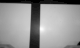

NO_SILVER (100 %)



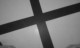

NO_SILVER (100 %)



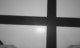

NO_SILVER (100 %)



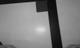

NO_SILVER (100 %)



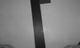

NO_SILVER (69 %)



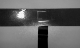

SILVER    (100 %)



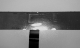

SILVER    (100 %)



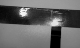

NO_SILVER (100 %)



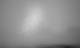

NO_SILVER (100 %)



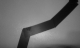

NO_SILVER (100 %)



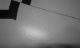

NO_SILVER (100 %)



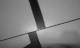

NO_SILVER (100 %)



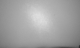

NO_SILVER (98 %)



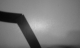

NO_SILVER (100 %)



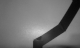

NO_SILVER (100 %)



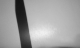

NO_SILVER (100 %)



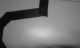

NO_SILVER (100 %)



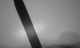

NO_SILVER (100 %)



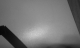

NO_SILVER (100 %)



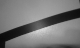

NO_SILVER (100 %)



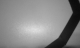

NO_SILVER (100 %)



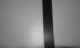

NO_SILVER (100 %)



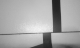

NO_SILVER (100 %)



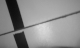

NO_SILVER (100 %)



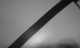

NO_SILVER (100 %)



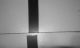

NO_SILVER (100 %)



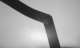

NO_SILVER (100 %)



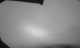

NO_SILVER (97 %)



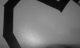

NO_SILVER (100 %)



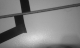

NO_SILVER (100 %)



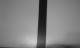

NO_SILVER (100 %)



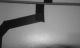

NO_SILVER (100 %)



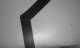

NO_SILVER (100 %)



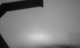

NO_SILVER (100 %)



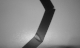

NO_SILVER (100 %)



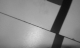

NO_SILVER (100 %)



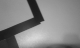

NO_SILVER (100 %)



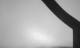

NO_SILVER (100 %)



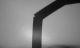

NO_SILVER (100 %)



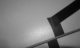

NO_SILVER (100 %)



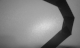

NO_SILVER (100 %)



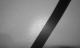

NO_SILVER (100 %)



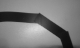

NO_SILVER (100 %)



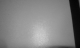

NO_SILVER (100 %)



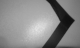

NO_SILVER (100 %)



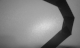

NO_SILVER (100 %)



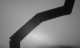

NO_SILVER (100 %)



In [6]:
test_images = []
original_images = []
#for img in os.listdir(TEST_IMAGES_PATH):
for img in os.listdir(TEST_IMAGES_PATH):
  image = cv2.imread(TEST_IMAGES_PATH + "/" + img, cv2.IMREAD_GRAYSCALE)
  original_images.append(image)
  image = image.astype(np.float32)
  image = np.expand_dims(image, axis=0)
  image = np.expand_dims(image, axis=3)
  test_images.append(image)

interpreter = tf.lite.Interpreter(model_path=MODEL_OUTPUT_PATH)
interpreter.allocate_tensors()

output = interpreter.get_output_details()[0]
input = interpreter.get_input_details()[0]

for i, image in enumerate(test_images):
  interpreter.set_tensor(input['index'], image)
  interpreter.invoke()
  out = interpreter.get_tensor(output['index'])
  cv2_imshow(original_images[i])
  if(out[0][0] > out[0][1]):
    print(f"SILVER    ({int(np.round(out[0][0] * 100))} %)")
  else:
    print(f"NO_SILVER ({int(np.round(out[0][1] * 100))} %)")
  print("")

# Quantize model

In [ ]:
import tensorflow as tf
import random

QUANT_MODEL_OUTPUT_PATH = '/content/drive/MyDrive/silver_quant.tflite'

def representative_data_gen():
  #for img in os.listdir(TEST_IMAGES_PATH):
  for img in os.listdir(SILVER_PATH):
    image = cv2.imread(SILVER_PATH + "/" + img, cv2.IMREAD_GRAYSCALE)
    if image is None:
      continue
    original_images.append(image)
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=3)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.float32
tflite_model = converter.convert()

with open(QUANT_MODEL_OUTPUT_PATH, 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


# Test quantized model

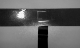

SILVER    (100 %)



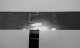

SILVER    (100 %)



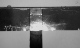

SILVER    (100 %)



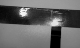

SILVER    (100 %)



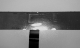

SILVER    (100 %)



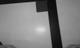

NO_SILVER (100 %)



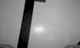

NO_SILVER (100 %)



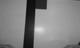

NO_SILVER (100 %)



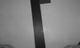

NO_SILVER (100 %)



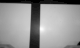

NO_SILVER (100 %)



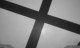

NO_SILVER (100 %)



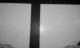

NO_SILVER (100 %)



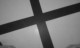

NO_SILVER (100 %)



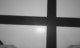

NO_SILVER (100 %)



In [ ]:
test_images = []
original_images = []
#for img in os.listdir(TEST_IMAGES_PATH):
for img in os.listdir(TEST_IMAGES_PATH):
  image = cv2.imread(TEST_IMAGES_PATH + "/" + img, cv2.IMREAD_GRAYSCALE)
  image = image.astype(np.uint8)
  original_images.append(image)
  image = np.expand_dims(image, axis=0)
  image = np.expand_dims(image, axis=3)
  test_images.append(image)

interpreter = tf.lite.Interpreter(model_path=QUANT_MODEL_OUTPUT_PATH)
interpreter.allocate_tensors()

output = interpreter.get_output_details()[0]
input = interpreter.get_input_details()[0]

for i, image in enumerate(test_images):
  interpreter.set_tensor(input['index'], image)
  interpreter.invoke()
  out = interpreter.get_tensor(output['index'])
  cv2_imshow(original_images[i])
  if(out[0][0] > out[0][1]):
    print(f"SILVER    ({int(np.round(out[0][0] * 100))} %)")
  else:
    print(f"NO_SILVER ({int(np.round(out[0][1] * 100))} %)")
  print("")